---
title: Dask Flood Mapper
---

#### 📌 Introduction 

This notebook is intend to show how  to generate flood maps using Dask.  The example shows a flood event occurred in Nothern Germany on 20.10.2023, specifically at the area around Zingst at the Baltic coast ([Wikipedia info](https://en.wikipedia.org/wiki/Storm_Babet)).

The notebook is mainly divided into the setup, data prepraration, calculation of required parameters, visualizing the results and storing the output. Some of the parameters are defined separately at the config.yaml file and most of the functions come from a local module called floodmapper.

#### 🎯 Summary  

* [Libraries](#libraries) 
* [Setup](#setup)
* [Load and prepare the data](#load)
    * [Sentinel 1 sig0 20m](#1.-sentinel-1-sig0-20m)
    * [Harmonic parameters](#2.-harmonic-parameters)
    * [Local incidence angles](#3.-local-incidence-angles)
    * [ESA World Cover from Terrascope](#4-esa-world-cover-from-terrascope)
* [Calculations](#calculations)
    * [Fuse cube](#fuse-cube)
    * [Likelihoods](#likelihoods)
    * [Flood mapping](#flood-mapping)
    * [Post processing](#post-processing)
    * [Removal of Speckles](#removal-of-speckles)
* [Results](#results)
* [Store output](#store)




<div class="alert alert-block alert-warning"><b>! </b> Before using the floodmapper module, 
 please fix the path by running the cell below. </div>

In [5]:
import sys
import os
from pathlib import Path

src_path = Path(os.getcwd()).resolve().parent / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

print(f"Added {src_path} to sys.path")


Added /Users/thaisbeham/Documents/Work/flood-mapper-forked/dask-flood-mapper/src to sys.path


#### 📚 Libraries <a id="libraries"></a>

In [7]:
#import required packages
import os
import pystac_client
from odc import stac as odc_stac
import xarray as xr
import hvplot.xarray
from flood.setup import client, config
from flood.calculation import calc_water_likelihood, harmonic_expected_backscatter, bayesian_flood_decision
from flood.processing import post_processing
from flood.compress import write_zarr_and_zip
from flood.extra import process_sig0_dc, process_datacube, process_wcover_data, calculate_flood_dc, remove_speckles
import dask

# set temporary directory for when Dask spills data from the workers memory to disk
dask.config.set(temporary_directory='/tmp')

## 🔧 Setup <a id="setup"></a>

This section will perform the required steps to allow further calculations. 

1. Initialize the Dask client (to avoid intercommunication, commonly when using `numpy` and `xarray` together)

In [8]:
# initialize the dask client
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.0.113:57045/status,
Dashboard: http://192.168.0.113:57045/status,Workers: 3
Total threads: 6,Total memory: 24.00 GiB
Status: running,Using processes: False
Comm: inproc://192.168.0.113/6278/1,Workers: 3
Dashboard: http://192.168.0.113:57045/status,Total threads: 6
Started: 13 minutes ago,Total memory: 24.00 GiB
Comm: inproc://192.168.0.113/6278/4,Total threads: 2
Dashboard: http://192.168.0.113:57046/status,Memory: 8.00 GiB
Nanny: None,


2. Set desirable time range and load eodc catalog and parameters

In [9]:
# define the desirable timerange
# format: yyyy-mm-dd/yyyy-mm-dd
time_range = "2022-10-11/2022-10-25"

# load eocd catalog
eodc_catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1")

# load the parametrs from yaml file
crs = config["base"]["crs"]
chunks = config["base"]["chunks"]
resolution =  config["base"]["resolution"]
bbox = config["base"]["bbox"]
groupby = config["base"]["groupby"]

## 🛰🌍 Load and prepare the data <a id="load"></a>

4 data cubes need to be loaded and processed for obtaining the flood map.

### 1. Sentinel 1 sig0 20m
Sentinel-1 microwave backscatter ($\sigma_0$ [1]) at a 20 meter resolution data cube.

Search in the catalog  and collect items

In [10]:
# search for the collection Sentinel1 inside the EODC catalog
search = eodc_catalog.search(
    collections="SENTINEL1_SIG0_20M",
    bbox=bbox,
    datetime=time_range,
)

# discover the required items
items_sig0 = search.item_collection()

Load the items with VV polarization

In [11]:
# load the data cube with the defined parameters
sig0_dc = odc_stac.load(items_sig0,
                        bands= "VV",
                        crs=crs,
                        chunks=chunks,
                        resolution=resolution,
                        bbox=bbox,
                        resampling="bilinear",
                        groupby=groupby,
                        )

Rescale the variable, fill empty values with np.nan and add the orbit names. Removal of duplicate time dimensions from data cube, extract orbit names. The data is persisted to retain it as delayed object in the workers memory. 

In [12]:
sig0_dc, orbit_sig0 = process_sig0_dc(sig0_dc, items_sig0, bands= "VV")

In [13]:
print(orbit_sig0)

['D168' 'A44' 'A44' 'D66' 'D95' 'A146' 'A146' 'D168']


### 2. Harmonic parameters

The harmornical parameters data cube is loaded to allow later the calculation of likelihoods of $P(\sigma^0|flood)$ and $P(\sigma^0|nonflood)$.

In [14]:
# search the harmonica parameters from the EODC catalog
search = eodc_catalog.search(
    collections="SENTINEL1_HPAR",
    bbox=config["base"]["bbox"]
)

items_hpar = search.item_collection()

Load the data as lazy object and process it.

In [15]:
# load the harmonical parameters data cube 
hpar_dc = odc_stac.load(items_hpar,
                        bands=("C1", "C2", "C3", "M0", "S1", "S2", "S3", "STD"),
                        crs=crs,
                        chunks=chunks,
                        resolution=resolution,
                        bbox=bbox,
                        groupby=groupby,
                        )

In [16]:
hpar_dc = process_datacube(hpar_dc, items_hpar,orbit_sig0, bands=("C1", "C2", "C3", "M0", "S1", "S2", "S3", "STD"))

hpar_dc

<xarray.Dataset> Size: 2GB
Dimensions:      (orbit: 8, latitude: 1668, longitude: 4445)
Coordinates:
  * latitude     (latitude) float64 13kB 54.6 54.6 54.6 54.6 ... 54.3 54.3 54.3
  * longitude    (longitude) float64 36kB 12.3 12.3 12.3 12.3 ... 13.1 13.1 13.1
    spatial_ref  int32 4B 4326
  * orbit        (orbit) object 64B 'D168' 'A44' 'A44' ... 'A146' 'A146' 'D168'
Data variables:
    C1           (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    C2           (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    C3           (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    M0           (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    S1           (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    S2           (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    S3           (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>
    STD          (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>

### 3. Local Incidence Angles

Local incidence angles of microwave backscattering data cube is important for calculating reference backscatter values for water bodies, using a similar procedure as for harmonic parameters.

In [17]:
# search the data from the EODC catalog
search = eodc_catalog.search(
    collections="SENTINEL1_MPLIA",
    bbox=config["base"]["bbox"]
)

items_plia = search.item_collection()

Load the data as lazy object and process it.

In [18]:
# load the local incidence angles data
plia_dc = odc_stac.load(items_plia,
                        bands="MPLIA",
                        crs=crs,
                        chunks=chunks,
                        resolution=resolution,
                        bbox=bbox,
                        groupby=groupby,
                        )

plia_dc = process_datacube(plia_dc, items_plia,orbit_sig0, bands="MPLIA")


plia_dc

<xarray.Dataset> Size: 237MB
Dimensions:      (orbit: 8, latitude: 1668, longitude: 4445)
Coordinates:
  * latitude     (latitude) float64 13kB 54.6 54.6 54.6 54.6 ... 54.3 54.3 54.3
  * longitude    (longitude) float64 36kB 12.3 12.3 12.3 12.3 ... 13.1 13.1 13.1
    spatial_ref  int32 4B 4326
  * orbit        (orbit) object 64B 'D168' 'A44' 'A44' ... 'A146' 'A146' 'D168'
Data variables:
    MPLIA        (orbit, latitude, longitude) float32 237MB dask.array<chunksize=(1, 1300, 1300), meta=np.ndarray>

In [19]:
for var_name, var in plia_dc.data_vars.items():
    print(f"{var_name}: type={type(var.data)}, has_chunks={hasattr(var.data, 'chunks')}, chunks={getattr(var.data, 'chunks', None)}")

MPLIA: type=<class 'dask.array.core.Array'>, has_chunks=True, chunks=((1, 1, 1, 1, 1, 1, 1, 1), (1300, 368), (1300, 1300, 1300, 545))


### 4. ESA World Cover from Terrascope

For flood mapping, only microwave backscattering over previously dry land is considered. Therefore, water bodies need to be masked. This is achieved using ESA World Cover data from the following STAC catalog.

In [20]:
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

# get the ESA World Cover data from STAC catalogue
wcover_catalog = pystac_client.Client.open('https://services.terrascope.be/stac/')

In [21]:
# discover the required items
search = wcover_catalog.search(
    collections= "urn:eop:VITO:ESA_WorldCover_10m_2021_AWS_V2",
    bbox=bbox
)

items_wcover = search.item_collection()

Load the data as lazy object, process and persist it

In [22]:
# Load the data lazily
wcover_dc = odc_stac.load(items_wcover,
                        crs=crs,
                        chunks=chunks,
                        resolution=resolution,
                        bbox=bbox,
                       )

wcover_dc = process_wcover_data(wcover_dc)

wcover_dc

<xarray.Dataset> Size: 30MB
Dimensions:      (latitude: 1668, longitude: 4445)
Coordinates:
  * latitude     (latitude) float64 13kB 54.6 54.6 54.6 54.6 ... 54.3 54.3 54.3
  * longitude    (longitude) float64 36kB 12.3 12.3 12.3 12.3 ... 13.1 13.1 13.1
    spatial_ref  int32 4B 4326
Data variables:
    wcover       (latitude, longitude) float32 30MB dask.array<chunksize=(1300, 1300), meta=np.ndarray>

## ⚙️ Calculations <a id="calculations"></a>

In this section it will be carried out the calculations for obtaing the flood map.

### Fuse cube

The four data cubes ([Sentinel 1](#sentinel-1-sig0-20m), [Harmonic parameters](#harmonic-parameters), [Local Incidence Angles](#local-incidence-angles) and [ESA World Cover](#esa-world-cover-from-terrascope)) are fused together, and values with a HAND value above zero are filtered. After this, orbit coordinates are removed, along with time slices that do not contain any land backscattering data.

In [23]:
flood_dc = calculate_flood_dc(sig0_dc, plia_dc, hpar_dc, wcover_dc)

### Likelihoods

The likelihoods of microwave backscattering under flooded and non-flooded conditions are now ready to be calculated for water and land.

In [24]:
# Water
flood_dc["wbsc"] = calc_water_likelihood(flood_dc)

# Land
flood_dc["hbsc"] = harmonic_expected_backscatter(flood_dc)

### Flood mapping

With the likelihoods of microwave backscattering for flooded and non-flooded conditions calculated, the next step is to determine the probability that a given pixel is flooded based on its backscatter value, $\sigma^0$. These probabilities, known as *posteriors*, require one more piece of information: the prior probability of a pixel being flooded $P(F)$ or not flooded $P(NF)$.  

Since these probabilities are unknown, Bayesian statistics allows starting with an initial estimate, called a *prior*. This represents an assumption made before analyzing the data. A reasonable choice is a 50-50 chance of flooding versus non-flooding, like a coin flip. Using this prior and the previously calculated likelihoods, the probability of backscattering $P(\sigma^0)$ is computed as a weighted average of the water and land likelihoods. This ensures that the posteriors fall within a valid probability range of 0 to 1.  

The following function calculate these priors, which are essential for predicting whether a land pixel is likely to have become flooded.


In [25]:
# Calculate the prior probability of a pixel being flooded or not flooded.
flood_dc[["nf_post_prob", "f_post_prob", "decision"]] = bayesian_flood_decision(flood_dc)

### Post processing

The flood map is improved by filtering out observations with low sensitivity to flooding, based on the following criteria:

* Masking of Exceeding Incidence Angles
* Identification of Conflicting Distributions
* Removal of Measurement Outliers
* Denial of High Uncertainty on Decision

In [26]:
# Filter out observations with low sensitivity to flooding
flood_output = post_processing(flood_dc)

### Removal of speckles

The next step improves the flood maps by removing "speckles" — small, isolated areas of one or a few pixels, likely caused by surface scattering. Since small, single-pixel floods are unlikely, a smoothing filter is applied using a rolling median along both the x and y-axes to remove these speckles.

In [27]:
# Remove speckles usimg a rolling median
flood_output = remove_speckles(flood_output)
flood_output

<xarray.DataArray 'decision' (time: 6, latitude: 1668, longitude: 4445)> Size: 356MB
dask.array<where, shape=(6, 1668, 4445), dtype=float64, chunksize=(1, 1302, 1302), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 13kB 54.6 54.6 54.6 54.6 ... 54.3 54.3 54.3
  * longitude    (longitude) float64 36kB 12.3 12.3 12.3 12.3 ... 13.1 13.1 13.1
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 48B 2022-10-11T05:25:01 ... 2022-10-23...

## 🔍 Results <a id="results"></a>

After the previous calculations, it is possible to visualize the plot.

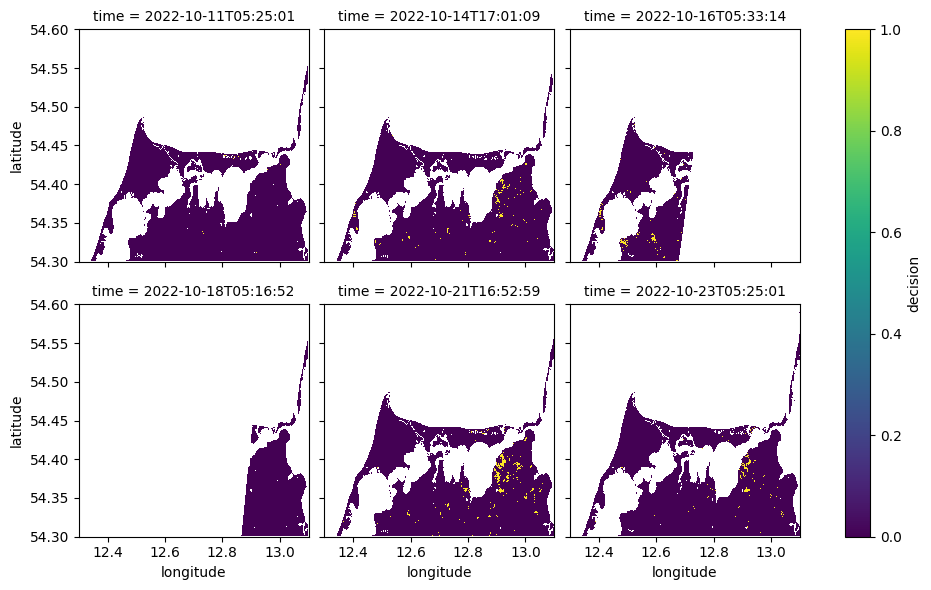

In [28]:
flood_output.plot(col="time", col_wrap=3)


The following graphic displays the data superimposed on a map, with a slider to show which areas become flooded over time.

In [31]:
flood_output.hvplot.quadmesh(x='longitude', y='latitude', geo=True, widget_location='bottom', rasterize=True, \
                            project=True, clim=(0,1), cmap=["rgba(0, 0, 1, 0.1)","darkred"], tiles=True, \
                            clabel="        non-flood                                        flood")

ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.

## 💾 Store output <a id="store"></a>

The visualization can be stored in .zarr format with the following function.

fs_out = "flood_output.zarr"
write_zarr_and_zip(flood_output.chunk(chunks), fs_out)

In [ ]:
#Close your local Dask Cluster
#It is always a good practice to close the Dask cluster you created.

client.shutdown()